### Preprocess sales to find seasonality

Extract the trend using LOESS and derive a heartbeat monitor from it

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim

import umap.umap_ as umap
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
#plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10/1.5
fig_w = 18/1.5

# inliners
fcn_compare = lambda a,b: abs(a-b)/max(a,b)
fcn_compare_snap_vs_regular = lambda snap,reg: snap/reg
mapper_family_to_category = fhelp.cfav_get_map_dept_to_cat()

In [2]:
dataFolder = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita')
xlsx_path = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita')
graphsFolder = fhelp.fullfile(dataFolder, 'graphs_cannibalisation')

In [3]:
dept_id = 'PREPARED_FOODS'
dept_id = 'DAIRY'
#dept_id = 'PRODUCE'
#dept_id = 'BREAD_BAKERY'

#dept_id = 'DELI'
#dept_id = 'LIQUOR,WINE,BEER'



store_name = 'Pichincha_47_A_14'
store_name = 'Pichincha_49_A_11'
#store_name = 'Pichincha_44_A_5'
#store_name = 'Pichincha_6_D_13'



do_save_decomposition = True

In [4]:
# Read departement sales for the current store
category_id = mapper_family_to_category.get(dept_id, '')
foldername = os.path.join(dataFolder, category_id, dept_id, 'store_sales')
filename = os.path.join(foldername, f'{store_name}.pickle')
df_store = fhelp.readPickleFile(filename)

sales_vars = [iVar for iVar in df_store.columns if 'sales-' in iVar]
promotion_vars = [iVar for iVar in df_store.columns if 'promotion_flag-' in iVar]

num_skus = len(sales_vars)
print(f'Number of SKUs {num_skus}...')

df_store.head(2)

Number of SKUs 242...


,date,weekdays,sales-DAIRY_122095-Pichincha_49_A_11,promotion_flag-DAIRY_122095-Pichincha_49_A_11,sales-DAIRY_123347-Pichincha_49_A_11,promotion_flag-DAIRY_123347-Pichincha_49_A_11,sales-DAIRY_129635-Pichincha_49_A_11,promotion_flag-DAIRY_129635-Pichincha_49_A_11,sales-DAIRY_158842-Pichincha_49_A_11,promotion_flag-DAIRY_158842-Pichincha_49_A_11,...,promotion_flag-DAIRY_2086882-Pichincha_49_A_11,sales-DAIRY_2087374-Pichincha_49_A_11,promotion_flag-DAIRY_2087374-Pichincha_49_A_11,sales-DAIRY_2087543-Pichincha_49_A_11,promotion_flag-DAIRY_2087543-Pichincha_49_A_11,sales-DAIRY_2087567-Pichincha_49_A_11,promotion_flag-DAIRY_2087567-Pichincha_49_A_11,sales-DAIRY_2112404-Pichincha_49_A_11,promotion_flag-DAIRY_2112404-Pichincha_49_A_11,total_units
0,2017-01-01,Sunday,0.0,False,0.0,False,0.0,False,0.0,False,...,False,0.0,False,0.0,False,0.0,False,0.0,False,0.0
1,2017-01-02,Monday,26.0,True,4.0,False,72.0,True,21.0,False,...,False,0.0,False,0.0,False,0.0,False,0.0,False,4510.0


### Plot LOESS decomposition of the department sales
The one commented is the original figure, whereas the one that runs produces the plot for the paper

### Same figure, adapted to the paper

/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


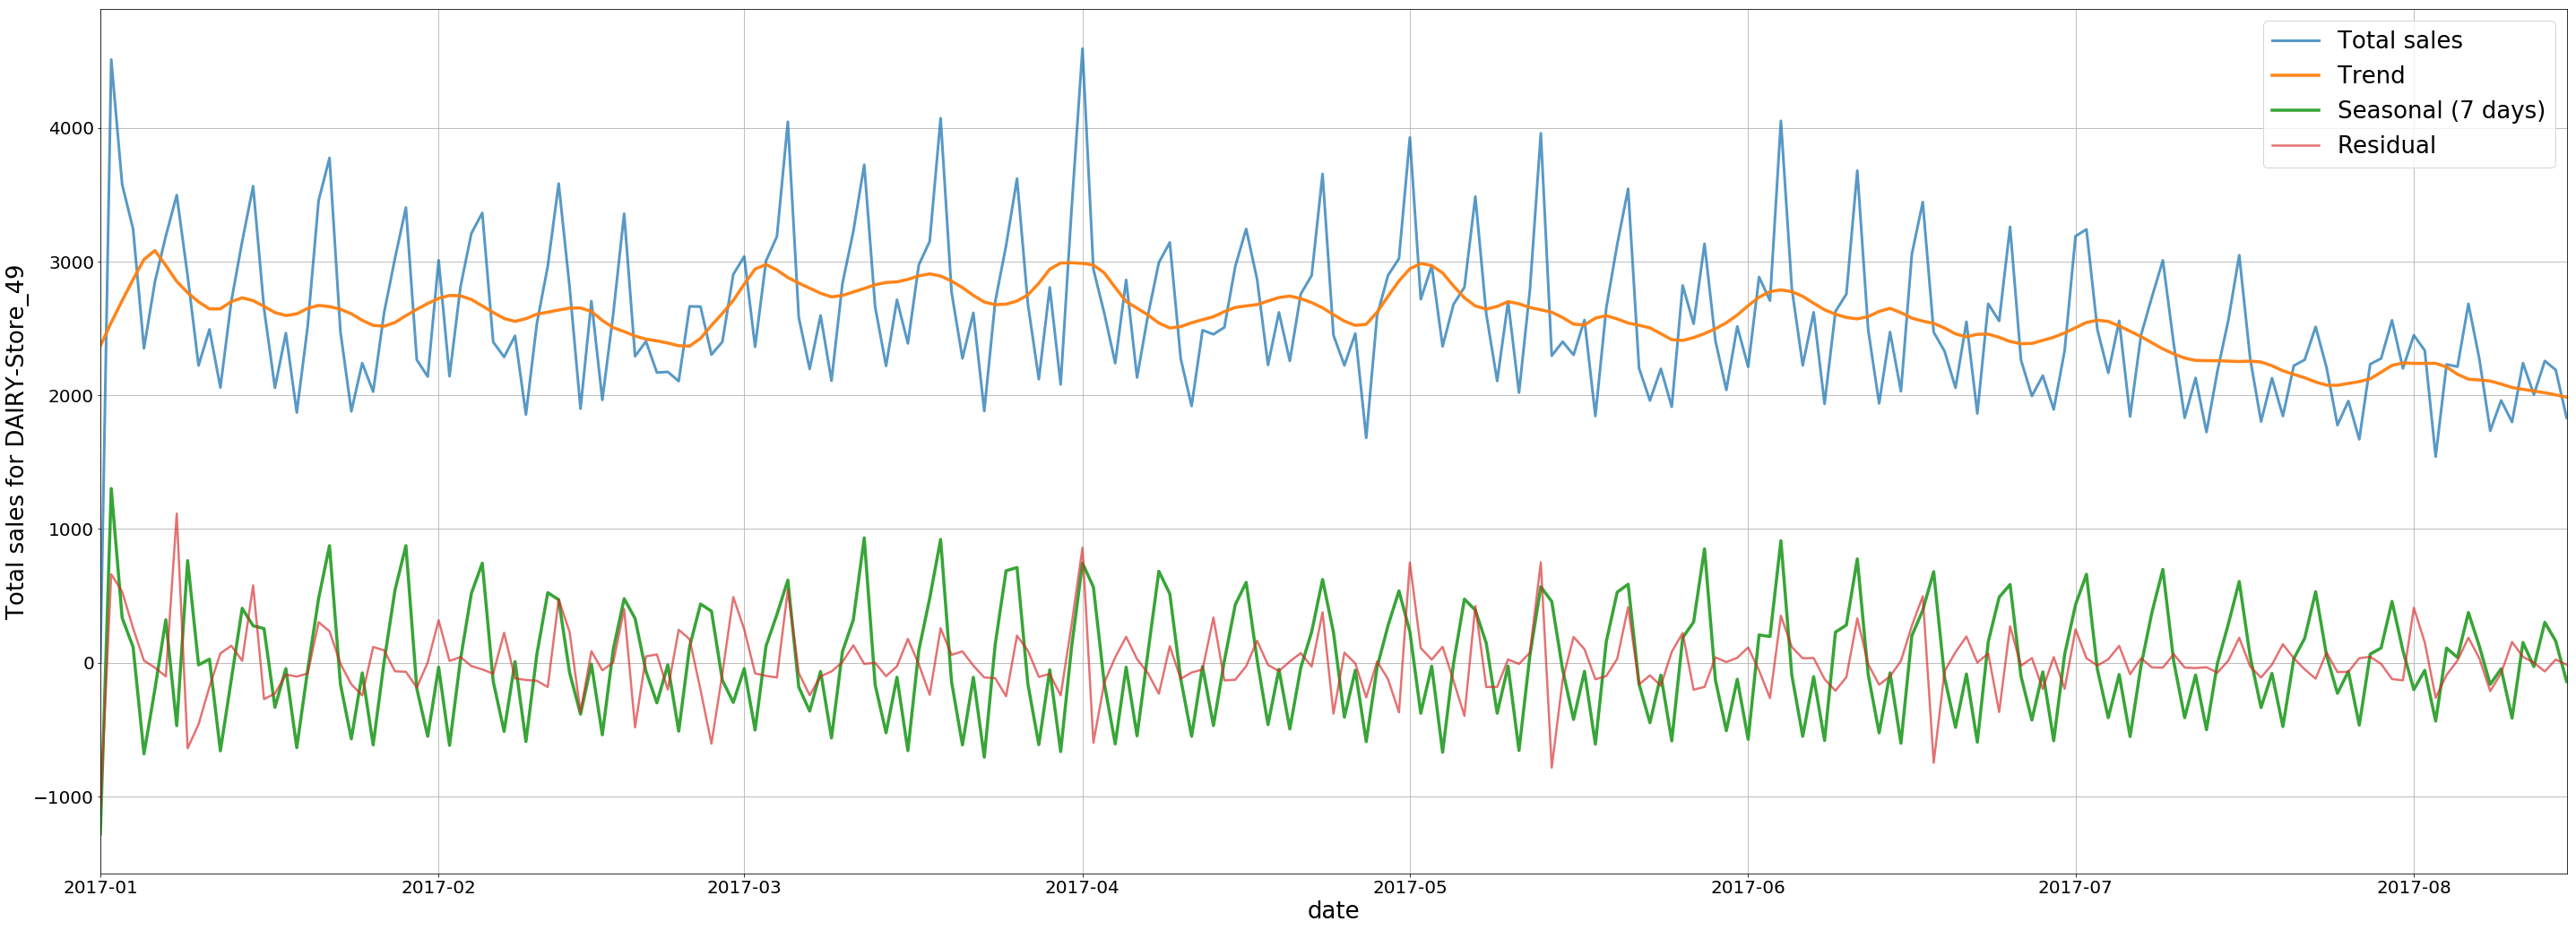

In [15]:
store_alias = f'''Store_{store_name.split('_')[1]}'''
f, ax = plt.subplots(1,1,figsize=(fig_w*1.5*1.5, fig_h*1.5))
font_size = 26

plt.rcParams.update({'font.size': font_size})


x_axis = df_store.date
period_in_days=7



decomposition_results = fhelp.decompose_signal(df_store.total_units, period_in_days=period_in_days, minimum_heartbeat=0.85)
df_decomposition = pd.DataFrame(decomposition_results)

idx_store = 0


idx_axis = 0
'''ax.plot(x_axis, df_store.total_units, label=f'{dept_id} sales {store_alias}', 
        color=def_colours[idx_store], linewidth=2, alpha=0.75)'''

ax.plot(x_axis, df_store.total_units, label=f'Total sales', 
        color=def_colours[idx_store], linewidth=2+1, alpha=0.75)

ax.plot(x_axis, df_decomposition['trend'], label=f'Trend', 
        color=def_colours[idx_store+1], linewidth=2.5+1, alpha=0.95)

ax.plot(x_axis, df_decomposition['seasonal'], label=f'Seasonal ({period_in_days} days)',
        color=def_colours[idx_store+2], linewidth=2.5+1, alpha=0.95)

ax.plot(x_axis, df_decomposition['residual'], label=f'Residual',
        color=def_colours[idx_store+3], linewidth=1.5+1, alpha=0.65)


plt.legend()
plt.xlabel('date', fontsize=font_size)
#plt.ylabel(f'Total sales for {dept_id}-{store_name}')
plt.ylabel(f'Total sales for {dept_id}-{store_alias}',fontsize=font_size)
plt.grid(True)
plt.tight_layout()
plt.margins(0,0.05)

if do_save_decomposition:
    doLatex = False
    if doLatex:
        from matplotlib import rcParams
        rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
            "pgf.preamble": [
                r"\usepackage[utf8x]{inputenc}",
                r"\usepackage[T1]{fontenc}",
                r"\usepackage{cmbright}",
            ]
        })
        plt.savefig(f'Total sales for {dept_id}-{store_name}.pdf', bbox_inches="tight")
    else:
        plt.savefig(f'Total sales for {dept_id}-{store_name}.pdf', bbox_inches="tight")
else:
    plt.show()

In [6]:
total_sales_sku = df_store[sales_vars].sum(axis=0)

total_sales_sku = df_store[sales_vars].median(axis=0)
total_sales_sku = df_store[sales_vars].std(axis=0)
total_sales_sku = df_store[sales_vars].mean(axis=0)

In [7]:
import umap.umap_ as umap

# sku in R^{num_skus x days}
data_to_reduce = df_store[sales_vars].T.values

n_neighbors=5
min_dist=0.05
n_components=2
metric='euclidean'

# Reduce
reducer = umap.UMAP(n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric)

embedding = reducer.fit_transform(data_to_reduce)
embedding.shape



(242, 2)

In [8]:
df_embedding = pd.DataFrame(embedding, columns=[f'd{idx}' for idx in range(0, n_components)])
df_embedding['sku'] = sales_vars
#df_embedding['sku'] = df_embedding['sku'].apply(lambda s: s.split('-')[1])
df_embedding_ext = pd.merge(df_embedding, total_sales_sku.rename('sales'), how='inner', left_on='sku', right_on=total_sales_sku.index)
df_embedding_ext.head()

,d0,d1,sku,sales
0,6.372446,6.421607,sales-DAIRY_122095-Pichincha_49_A_11,8.638767
1,4.431508,6.911679,sales-DAIRY_123347-Pichincha_49_A_11,5.074890
2,14.222595,0.811905,sales-DAIRY_129635-Pichincha_49_A_11,27.625551
3,13.615421,2.690076,sales-DAIRY_158842-Pichincha_49_A_11,14.863436
4,5.992117,6.553858,sales-DAIRY_164088-Pichincha_49_A_11,6.814978


Text(0.5, 1.0, 'UMAP embedding SKU')

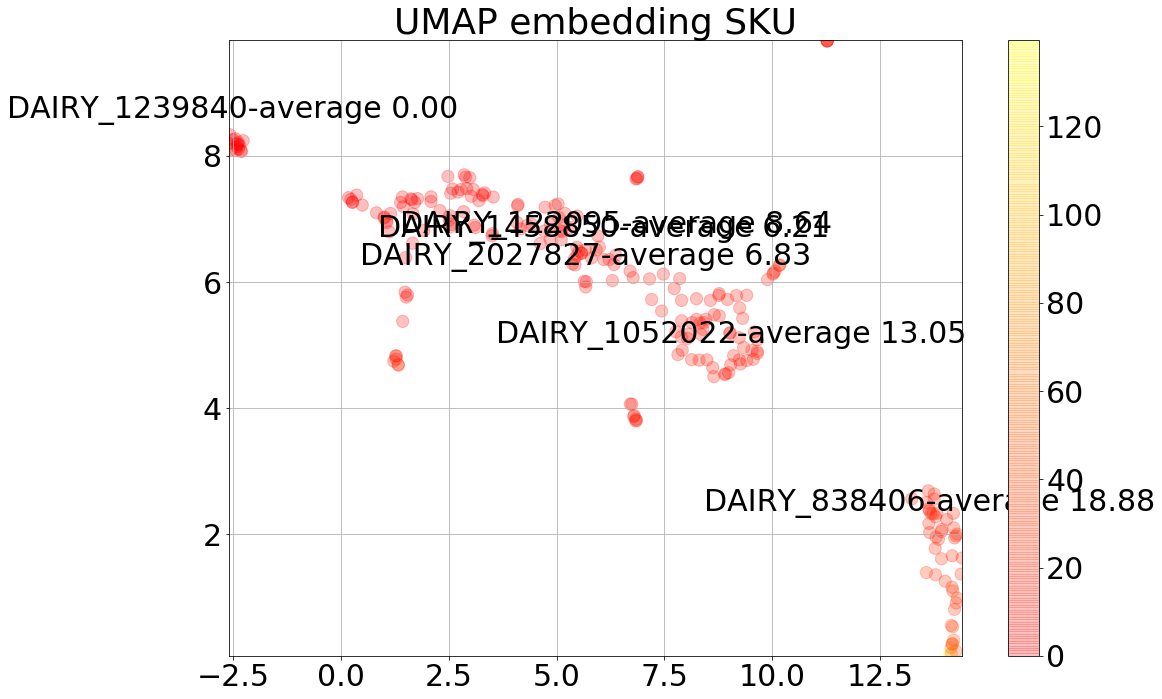

In [9]:
text_offset = 0.35
fig_h = 20/2
fig_w = 36/2
fig = plt.figure(figsize=(fig_w,fig_h))

plt.scatter(df_embedding_ext.d0, df_embedding_ext.d1, c=df_embedding_ext.sales, cmap='autumn', s=150, alpha=0.25)

'''
'''
for idx, irow in df_embedding_ext.iterrows():
    if idx % 45==0:
        sku_name = irow['sku']
        sku_sales = irow['sales']
        short_name = sku_name.split('-')[1]
        sku_to_show = f'{short_name}-average {sku_sales:3.2f}'
        plt.text(irow['d0'],irow['d1']+text_offset, s=sku_to_show, horizontalalignment='center') 

plt.grid(True)
plt.tight_layout()
plt.margins(0,0)
plt.colorbar()
plt.title('UMAP embedding SKU')

In [10]:
sku_name = irow['sku']
sku_sales = irow['sales']
short_name = sku_name.split('-')[1]
sku_to_show = f'{short_name}-median {sku_sales:3.2f}'
sku_to_show

'DAIRY_2112404-median 13.86'

In [11]:
xaxis = df_store.date

In [12]:
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=80)
    plt.title(title, fontsize=18)

In [13]:
draw_umap(data_to_reduce,  n_neighbors=5, n_components=3)

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

### Cluster the results

In [ ]:
from sklearn.cluster import DBSCAN, OPTICS, MiniBatchKMeans
col_names = df_embedding.columns.tolist()
col_names.remove('sku')

clustering1 = DBSCAN(eps=0.3, min_samples=5).fit(df_embedding[col_names].values)

df_embedding['labels'] = clustering1.labels_

In [ ]:
df_embedding.head()

In [ ]:
df_embedding[df_embedding.labels == 2]

In [ ]:
sku_A = 'sales-FOODS_1_018-CA_3'
sku_B = 'sales-FOODS_1_170-CA_3'


idx_store = 2

x_axis = df_store.dates
# Plot one store
f, ax = plt.subplots(1,1,figsize=(fig_w*1.5, fig_h/1.5))

df_store[sales_vars]

idx_axis = 0
ax.plot(x_axis, df_store[sku_A], label=f'Sales {sku_A}', 
        color=def_colours[idx_store], linewidth=2.5, alpha=0.75)

ax.plot(x_axis, df_store[sku_B], label=f'Sales {sku_B}', 
        color=def_colours[idx_store+1], linewidth=2.5, alpha=0.75)


plt.legend()
plt.xlabel('dates')
plt.ylabel(f'Store sales comparison')
plt.grid(True)
plt.show()

### Outlier detection

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
outlier_scores = LocalOutlierFactor(contamination=0.1).fit_predict(embedding)
sku_outliers = [sales_vars[idx] for idx in np.where(outlier_scores==-1)[0]]
sku_outliers

In [ ]:
x_axis = df_store.dates

for sku_B in sku_outliers[0:3]:

    idx_store = 1

    # Plot one store
    f, ax = plt.subplots(1,1,figsize=(fig_w*1.5, fig_h/1.5))

    idx_axis = 0
    ax.plot(x_axis, df_store[sku_B], label=f'Sales {sku_B}', 
            color=def_colours[idx_store], linewidth=2.5, alpha=0.75)